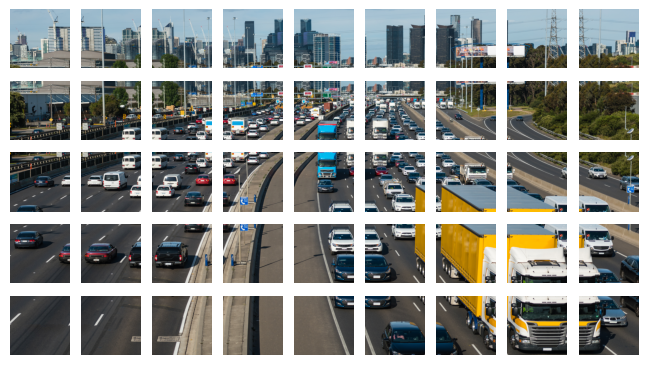

Number of generated images: 45


In [1]:
from nodes.MakeCropsDetectThem import MakeCropsDetectThem
from nodes.CombineDetectionsNode import CombineDetectionsNode
import cv2
import matplotlib.pyplot as plt

img_path = 'test_images/image-test.jpg'
img = cv2.imread(img_path)

element = MakeCropsDetectThem(image=img, model_path="yolov8m-seg.pt", segment=True, show_crops=True, shape_x=700, shape_y=700, resize_results=False)

In [22]:
element.crops[20].detected_xyxy_real

[[1423, 1510, 1670, 1686],
 [1556, 1312, 1749, 1445],
 [1302, 1077, 1443, 1160],
 [1092, 1430, 1319, 1587],
 [1050, 1077, 1236, 1252],
 [1430, 1182, 1614, 1312],
 [1177, 1304, 1416, 1489],
 [1559, 1119, 1713, 1234],
 [1663, 1050, 1749, 1168],
 [1050, 1324, 1075, 1463],
 [1473, 1068, 1622, 1170],
 [1463, 1050, 1600, 1111]]

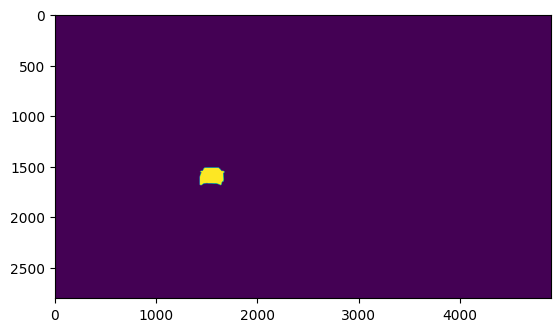

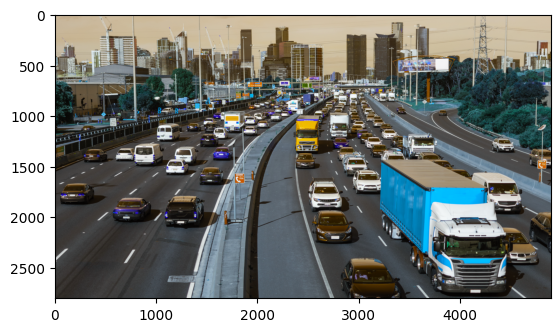

In [25]:
plt.imshow(element.crops[20].detected_masks_real[0]);
plt.show()
plt.imshow(element.crops[20].source_image_resized);

In [2]:
element = MakeCropsDetectThem(image=img, model_path="yolov8m-seg.pt", segment=False, show_crops=False, shape_x=700, shape_y=700, resize_results=False)
result = CombineDetectionsNode(element, nms_iou=0.7)

(165,)
(165, 4)
(0,)
(165,)
[150 135  19 129 131  64 138  70  71  72 140  73 110  65 137  59 161  83  90 121  84  66  85  60  75 133  86 141 139  91 132 159 162  10 160  50  87  95  76 130 154  96  51  88  98  58 142  61  31  41 122  32  42  89  92 136  99  12  53  62  67  54  13 145  23  24 101  25 151 123  15 124  55 113  33  78 114  16 102
 103  43 115   5 134   1  79 104  56 146 125  63 117 155  34 118 126 147 156   7  93  17 143  26   3  94 127  57  27 105  35 152 148  36  28  29 106 153  47  30 144 107 157  48 108  38 149  81  69 109 164 158  39  40  49]
(134,)
(134, 4)
(0,)
(134,)


In [6]:
result.detected_masks_list_full

[]